In [26]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import yaml
import os
import matplotlib.dates as mdates


import atlite
from shapely.geometry import box

In [2]:
def plot_generation_heatmap(df, cbar_label, title, save_name, vmax=150.):
    # Extract day of year and time of day in fractional hours
    df["day_of_year"] = df.index.dayofyear
    df["time_of_day"] = df.index.hour + df.index.minute / 60

    pivot = df.pivot(
        index="time_of_day", columns="day_of_year", values="thermal_output"
    )
    # 4. Plot the ratio
    plt.figure(figsize=(18, 6))

    plt.imshow(
        pivot,
        aspect="auto",
        origin="lower",
        cmap="jet",
        extent=[1, 366, 0, 24],   
        vmin=0,
        vmax=vmax,
    )

    plt.gca().invert_yaxis()
    plt.colorbar(label=cbar_label)
    plt.xlabel("Day of Year")
    plt.ylabel("Time of Day (Hour)")
    plt.title(title)
    plt.savefig(f"{save_name}.png", dpi=400)

In [3]:
def plot_scatter(df_scatter, title, color, ylabel, save_name, yrange=[0., 150.], logy=False, dash_one=False, markersize=5):
    plt.figure()
    plt.scatter(
        df_scatter.index,
        df_scatter["thermal_output"],
        s=markersize,
        color=color,
    )

    if dash_one:
        plt.axhline(y=1, color='black', linestyle='--')
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel(ylabel)
    plt.ylim(yrange)
    if logy:
        plt.yscale("log")
    plt.savefig(f"{save_name}.png", dpi=400)

In [4]:
def plot_monthly_bars(df, title, save_name, color):
    # Plot the monthly generation
    plt.figure(figsize=(10, 6))
    plt.bar(df.index, df["thermal_output"], color=color, width=15)
    plt.xlabel("Month")
    plt.ylabel("Thermal output (MW)")
    plt.title(title)
    plt.savefig(f"{save_name}.png", dpi=400)

In [5]:

# Define your target lat/lon (e.g., Ras Al Khair, Saudi Arabia)
# Lat lon for Ras Al Khair, Saudi Arabia

lat = 27.22
lon = 56.69

# Define a small bounding box around the point (ERA5 resolution is ~0.25°)
delta = 0.25  # half a grid cell
# Create bounding box and extract bounds
bounds_polygon = box(lon, lat, lon + delta, lat + delta)
bounds = bounds_polygon.bounds

# Create the cutout
cutout = atlite.Cutout(
    path="ras_al_khair_2018.nc",
    module="era5",
    bounds=bounds,
    time="2018",
)

cutout.prepare(["influx"], monthly_requests=True)

/central/groups/carnegie_poc/awongel/clab_concentrated_solar/concentrated_solar_capacity_factors/atlite/atlite/cutout.py:156: UserWarning: Arguments module, bounds, time are ignored, since cutout is already built.
  warn(


<Cutout "ras_al_khair_2018">
 x = 49.25 ⟷ 49.50, dx = 0.25
 y = 27.50 ⟷ 27.75, dy = 0.25
 time = 2018-01-01 ⟷ 2018-12-31, dt = h
 module = era5
 prepared_features = ['influx']

In [6]:
# Calculation of Capacity Factor and thermal_output for: SAM_solar_tower installation
pt = {
    "capacity factor": cutout.csp(
        installation="Glasspoint_parabolic_trough", capacity_factor=True
    ).rename("Glasspoint_parabolic_trough CF"),
    "specific generation": cutout.csp(installation="Glasspoint_parabolic_trough").rename(
        "Glasspoint_parabolic_trough SG"
    ),
}

# Calculation of Capacity Factor and Specific Generation for: lossless solar tower installation
ll = {
    "capacity factor": cutout.csp(
        installation="lossless_installation",
        technology="glasspoint parabolic trough",
        capacity_factor=True,
    ).rename("lossless_installation CF"),
    "specific generation": cutout.csp(
        installation="lossless_installation",
        technology="glasspoint parabolic trough",
    ).rename("lossless_installation SG"),
}

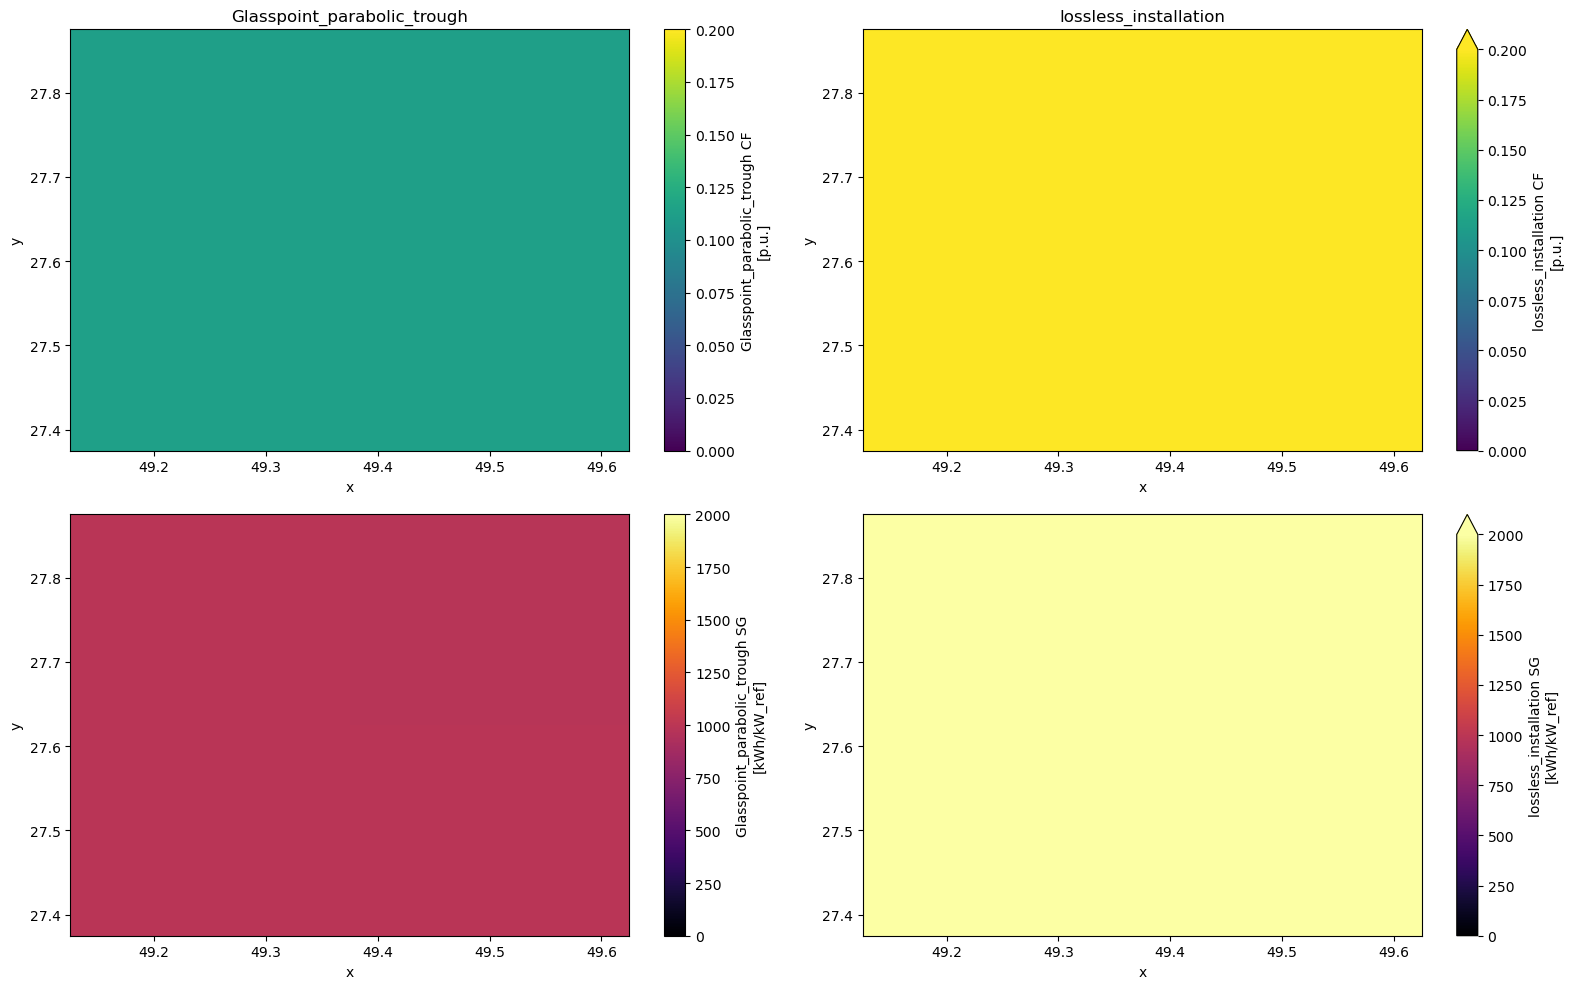

In [7]:
# Plot results side by side
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

pt["capacity factor"].plot(ax=axes[0][0], cmap="viridis", vmin=0, vmax=0.2)
pt["specific generation"].plot(ax=axes[1][0], cmap="inferno", vmin=0, vmax=2000)
axes[0][0].set_title("Glasspoint_parabolic_trough")

ll["capacity factor"].plot(ax=axes[0][1], cmap="viridis", vmin=0, vmax=0.2)
ll["specific generation"].plot(ax=axes[1][1], cmap="inferno", vmin=0, vmax=2000)
axes[0][1].set_title("lossless_installation")

# # Overlay Spanish borders
# for ax in axes.ravel():
#     bounds.plot(ax=ax, fc="none", ec="black")

fig.tight_layout()

In [8]:
# Layout with different installed capacity (due to different SAM model)
config = atlite.resource.get_cspinstallationconfig("SAM_parabolic_trough")
# solar field: from Glasspoint input
area = 240120 # m^2

# installed power = 950 W/m^2 * area = 90.2 MW
installed_power = config["r_irradiance"] * area / 1.0e6
print(installed_power)

# actual Ras Al Khair location
location = {"x": 27.503, "y": 56.69}

# Determine location on cutout grid
nearest_location = {
    v: cutout.grid[v].iloc[cutout.grid[v].sub(location[v]).abs().idxmin()]
    for v in ["x", "y"]
}

layout = xr.zeros_like(pt["capacity factor"])
layout.loc[dict(x=nearest_location["x"], y=nearest_location["y"])] = installed_power

228.114


In [9]:

# Extract the concenctrated solar power generation capacity factors
csp_power_generation = cutout.csp(
    # technology="glasspoint parabolic trough",
    # technology="parabolic trough",
    installation="Glasspoint_parabolic_trough",
    # installation="lossless_installation",
    # installation="SAM_parabolic_trough",
    # installation="SAM_solar_tower",
    # technology="solar tower",
    layout=layout,)

# # Save gridded data as netCDF files
# if not os.path.exists("rasal_khair_csp_CF_timeseries_2018.nc"):
#     csp_power_generation.to_netcdf(f"rasalkhair_csp_CF_timeseries_2018.nc")

In [10]:
csp_power_generation_df = csp_power_generation.to_dataframe()
# Drop dim_0 of index
csp_power_generation_df = csp_power_generation_df.reset_index(level=1, drop=True)
pd.set_option('display.max_rows', None)
print(csp_power_generation_df)

                     specific generation
time                                    
2018-01-01 00:00:00         0.000000e+00
2018-01-01 01:00:00         0.000000e+00
2018-01-01 02:00:00         0.000000e+00
2018-01-01 03:00:00         0.000000e+00
2018-01-01 04:00:00         0.000000e+00
2018-01-01 05:00:00         2.840189e+00
2018-01-01 06:00:00         2.429070e+01
2018-01-01 07:00:00         4.690247e+01
2018-01-01 08:00:00         6.069047e+01
2018-01-01 09:00:00         6.658960e+01
2018-01-01 10:00:00         6.574630e+01
2018-01-01 11:00:00         5.710899e+01
2018-01-01 12:00:00         4.023961e+01
2018-01-01 13:00:00         1.671029e+01
2018-01-01 14:00:00         0.000000e+00
2018-01-01 15:00:00         0.000000e+00
2018-01-01 16:00:00         0.000000e+00
2018-01-01 17:00:00         0.000000e+00
2018-01-01 18:00:00         0.000000e+00
2018-01-01 19:00:00         0.000000e+00
2018-01-01 20:00:00         0.000000e+00
2018-01-01 21:00:00         0.000000e+00
2018-01-01 22:00

In [11]:
# Extract the CSP generation data

# Set all values above 140 MW to 140 MW
csp_power_generation_df.loc[csp_power_generation_df["specific generation"] > 140, "specific generation"] = 140
print(csp_power_generation_df)

# Renaame specific generation to thermal output
csp_power_generation_df.rename(columns={"specific generation": "thermal_output"}, inplace=True)

                     specific generation
time                                    
2018-01-01 00:00:00         0.000000e+00
2018-01-01 01:00:00         0.000000e+00
2018-01-01 02:00:00         0.000000e+00
2018-01-01 03:00:00         0.000000e+00
2018-01-01 04:00:00         0.000000e+00
2018-01-01 05:00:00         2.840189e+00
2018-01-01 06:00:00         2.429070e+01
2018-01-01 07:00:00         4.690247e+01
2018-01-01 08:00:00         6.069047e+01
2018-01-01 09:00:00         6.658960e+01
2018-01-01 10:00:00         6.574630e+01
2018-01-01 11:00:00         5.710899e+01
2018-01-01 12:00:00         4.023961e+01
2018-01-01 13:00:00         1.671029e+01
2018-01-01 14:00:00         0.000000e+00
2018-01-01 15:00:00         0.000000e+00
2018-01-01 16:00:00         0.000000e+00
2018-01-01 17:00:00         0.000000e+00
2018-01-01 18:00:00         0.000000e+00
2018-01-01 19:00:00         0.000000e+00
2018-01-01 20:00:00         0.000000e+00
2018-01-01 21:00:00         0.000000e+00
2018-01-01 22:00

                     thermal_output  day_of_year  time_of_day
time                                                         
2018-01-01 00:00:00    0.000000e+00            1          0.0
2018-01-01 01:00:00    0.000000e+00            1          1.0
2018-01-01 02:00:00    0.000000e+00            1          2.0
2018-01-01 03:00:00    0.000000e+00            1          3.0
2018-01-01 04:00:00    0.000000e+00            1          4.0
2018-01-01 05:00:00    2.840189e+00            1          5.0
2018-01-01 06:00:00    2.429070e+01            1          6.0
2018-01-01 07:00:00    4.690247e+01            1          7.0
2018-01-01 08:00:00    6.069047e+01            1          8.0
2018-01-01 09:00:00    6.658960e+01            1          9.0
2018-01-01 10:00:00    6.574630e+01            1         10.0
2018-01-01 11:00:00    5.710899e+01            1         11.0
2018-01-01 12:00:00    4.023961e+01            1         12.0
2018-01-01 13:00:00    1.671029e+01            1         13.0
2018-01-

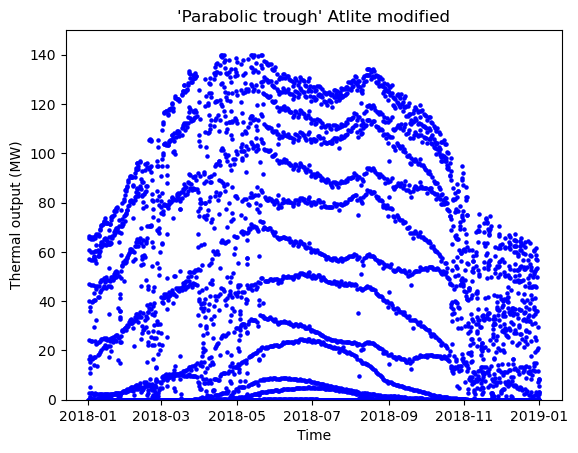

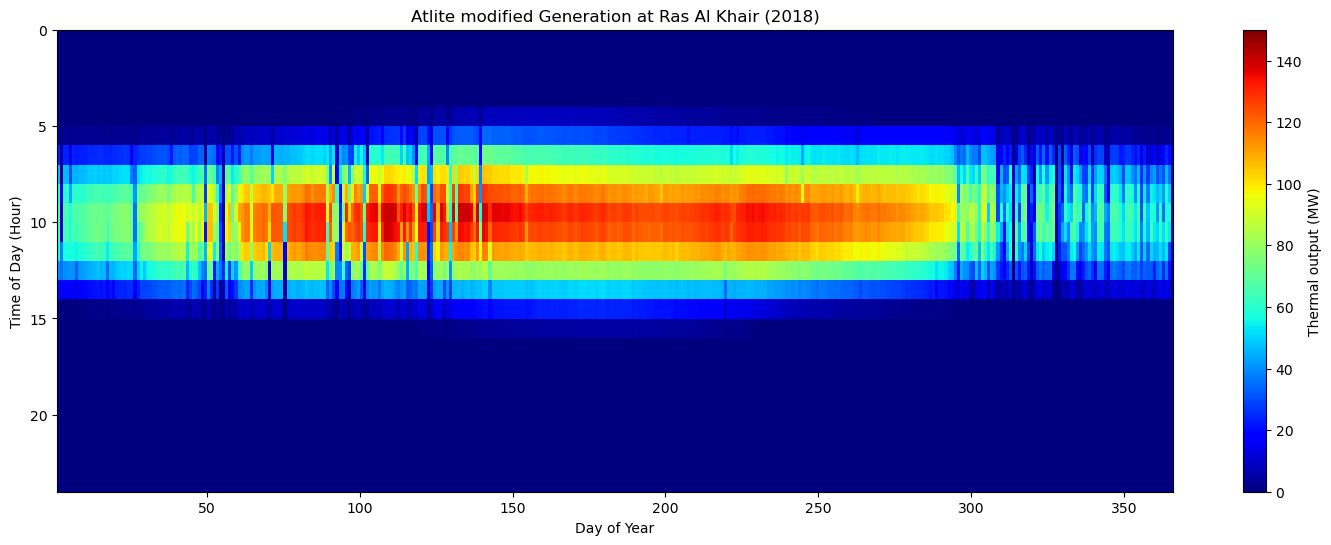

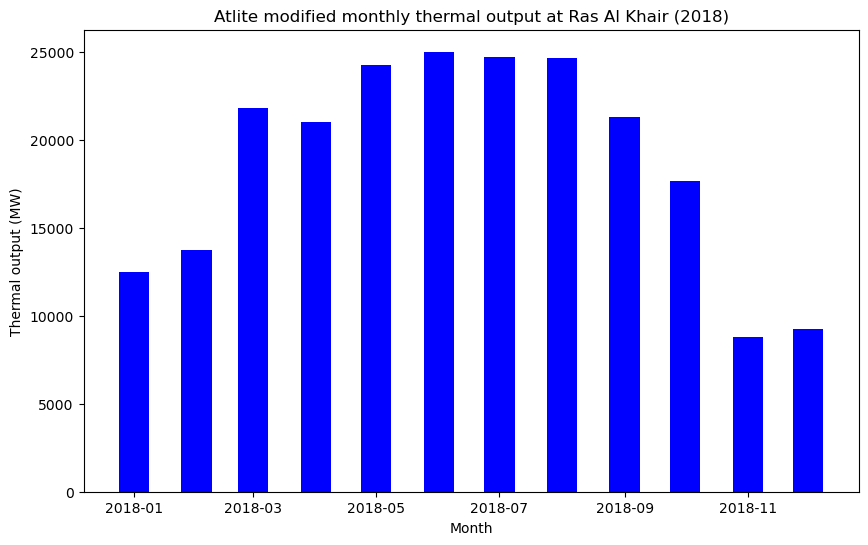

In [12]:
plot_scatter(csp_power_generation_df, "'Parabolic trough' Atlite modified", "blue", "Thermal output (MW)", save_name="cfs_comparison/generation_AtliteMod")

plot_generation_heatmap(csp_power_generation_df, "Thermal output (MW)", "Atlite modified Generation at Ras Al Khair (2018)", save_name="cfs_comparison/generation_AtliteMod_heatmap")

print(csp_power_generation_df)
#Save csp_power_generation_df to csv
csp_power_generation_df.to_csv("cfs_comparison/generation_AtliteMod.csv")
# Aggregate monthly and plot as bar chart
csp_power_generation_df_monthly = csp_power_generation_df.resample("MS").sum()

plot_monthly_bars(csp_power_generation_df_monthly, "Atlite modified monthly thermal output at Ras Al Khair (2018)", save_name="cfs_comparison/generation_AtliteMod_monthly_bar", color="blue")


In [13]:
# Read in Glasspoint data
path = "../../../input_files/SAM_glasspoint_data_generation_2018.csv"
glasspoint_data = pd.read_csv(path)

# Convert 'Day' and 'Hour' into a datetime column for the year 2018
# glasspoint_data["Datetime"] = pd.to_datetime("2018-01-01") + pd.to_timedelta(glasspoint_data["Day"] - 1, unit="D") + pd.to_timedelta(glasspoint_data["Hour"], unit="h")

if "representative" in path:
    # # Cut first 3 hours, then restart the time series from 00:00:00
    # glasspoint_data = glasspoint_data.iloc[3:]
    # glasspoint_data["Datetime"] = pd.date_range(start="2018-01-01 00:00:00", periods=len(glasspoint_data), freq="H")
    # Cut last 3 hours of atlite data
    csp_power_generation_df = csp_power_generation_df.iloc[:-3]

# # Sort by the new datetime column
# glasspoint_data = glasspoint_data.sort_values("Datetime").reset_index(drop=True)

# Rename Glasspoint Datetime to time
glasspoint_data.rename(columns={"Datetime": "time", "Annual thermal energy in Year 1 (kWt)":"thermal_output"}, inplace=True)
print(glasspoint_data)
print(csp_power_generation_df)

glasspoint_data["thermal_output"] = glasspoint_data["thermal_output"] / 1000 # Convert to MW
# Save time as datetime
glasspoint_data["time"] = pd.to_datetime(glasspoint_data["time"])

# Set time as index
glasspoint_data.set_index("time", inplace=True)

      Day  Hour  thermal_output                 time
0       1     0            0.00  2018-01-01 00:00:00
1       1     1            0.00  2018-01-01 01:00:00
2       1     2            0.00  2018-01-01 02:00:00
3       1     3            0.00  2018-01-01 03:00:00
4       1     4            0.00  2018-01-01 04:00:00
5       1     5            0.00  2018-01-01 05:00:00
6       1     6        53658.20  2018-01-01 06:00:00
7       1     7        69977.50  2018-01-01 07:00:00
8       1     8        66226.50  2018-01-01 08:00:00
9       1     9        70434.70  2018-01-01 09:00:00
10      1    10        73733.10  2018-01-01 10:00:00
11      1    11        58026.00  2018-01-01 11:00:00
12      1    12        23352.80  2018-01-01 12:00:00
13      1    13         8426.69  2018-01-01 13:00:00
14      1    14            0.00  2018-01-01 14:00:00
15      1    15            0.00  2018-01-01 15:00:00
16      1    16            0.00  2018-01-01 16:00:00
17      1    17            0.00  2018-01-01 17

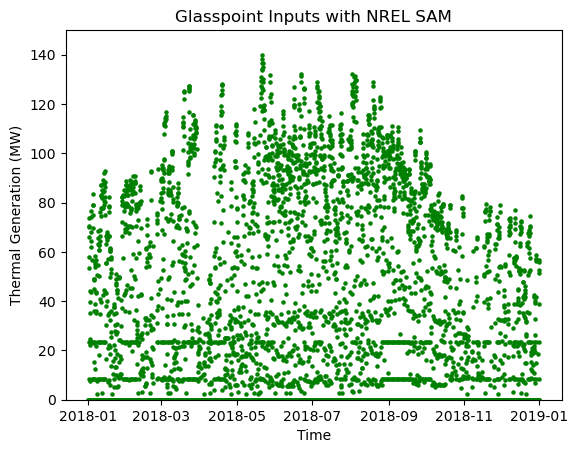

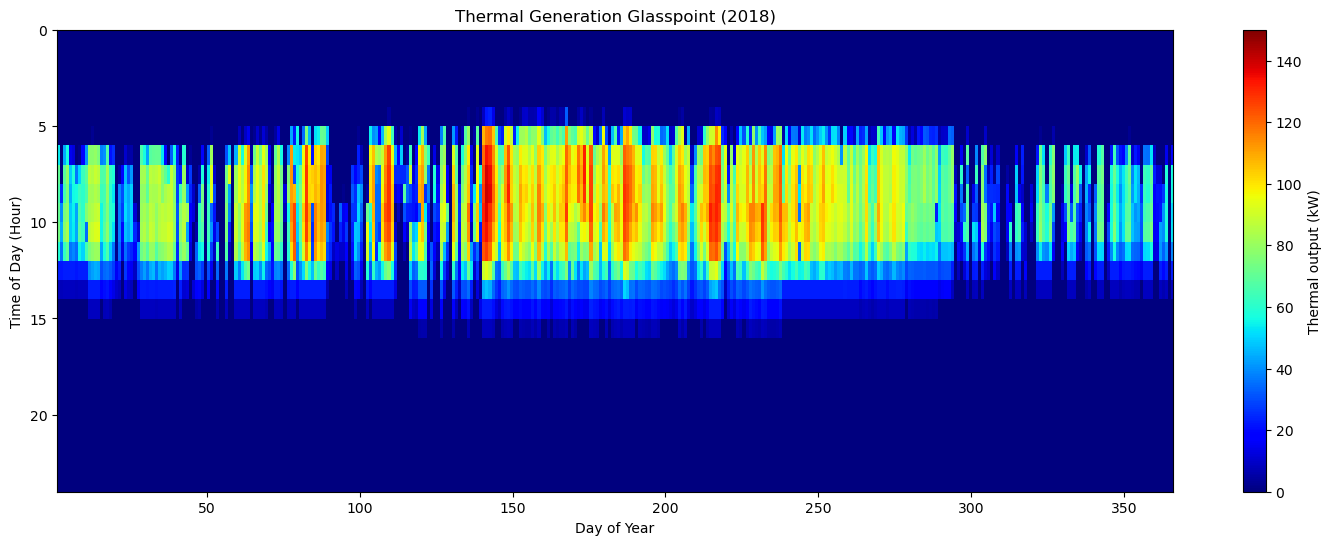

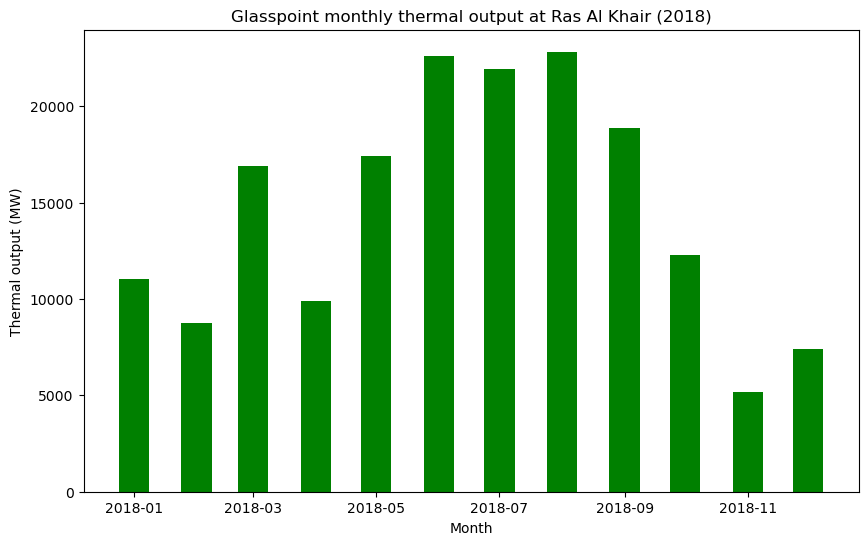

In [14]:
# Plot Annual Generation vs time
plot_scatter(glasspoint_data, "Glasspoint Inputs with NREL SAM", "green", "Thermal Generation (MW)", save_name="cfs_comparison/generation_GP")
plot_generation_heatmap(glasspoint_data, "Thermal output (kW)", "Thermal Generation Glasspoint (2018)", save_name="cfs_comparison/generation_GP_heatmap")

# Aggregate monthly and plot as bar chart
glasspoint_data_monthly = glasspoint_data.select_dtypes(include='number').resample("MS").sum()
plot_monthly_bars(glasspoint_data_monthly, "Glasspoint monthly thermal output at Ras Al Khair (2018)", save_name="cfs_comparison/generation_GP_monthly_bar", color="green")

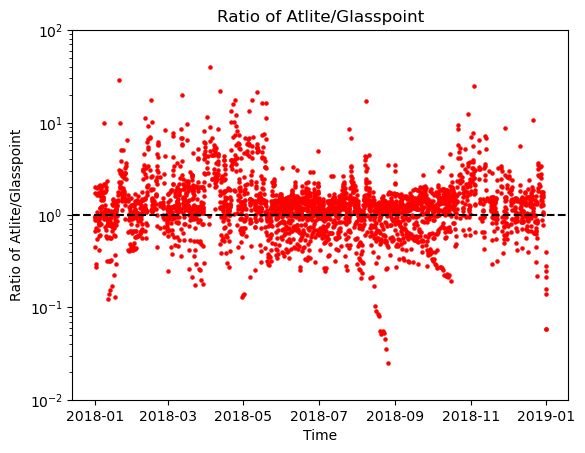

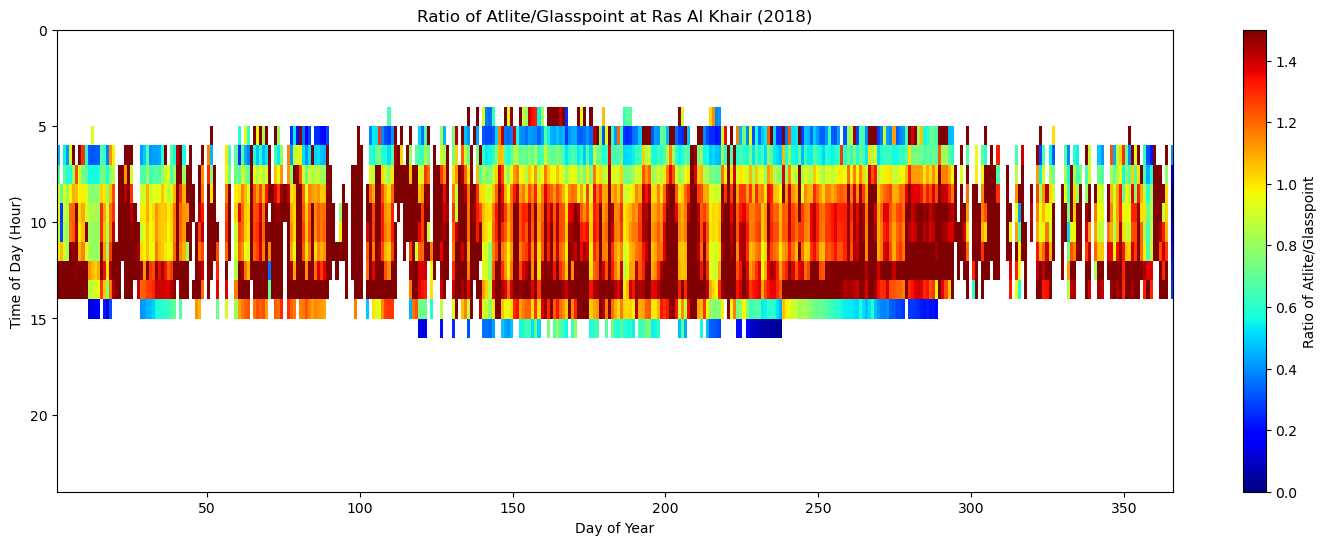

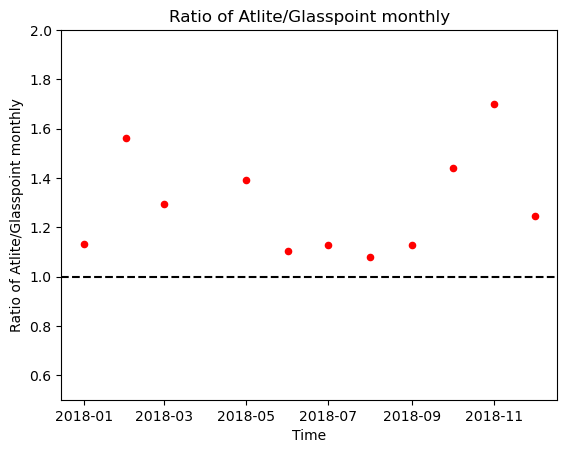

In [15]:
# Make a heatmap of the ratio of the Atlite and Glasspoint data


ratio_df = pd.DataFrame()
ratio_df["thermal_output"] = csp_power_generation_df["thermal_output"] / glasspoint_data["thermal_output"]

# set time as index
ratio_df.index = pd.to_datetime(ratio_df.index)

# Drop NaN values and infinite values
# ratio_df = ratio_df.replace([np.inf, -np.inf], np.nan).dropna()

plot_scatter(ratio_df, "Ratio of Atlite/Glasspoint", "red", "Ratio of Atlite/Glasspoint", save_name="cfs_comparison/generation_GP_Atlite_ratio_scatter", yrange=[1e-2, 1e2], logy=True, dash_one=True)
plot_generation_heatmap(ratio_df, "Ratio of Atlite/Glasspoint", "Ratio of Atlite/Glasspoint at Ras Al Khair (2018)", save_name="cfs_comparison/generation_GP_Atlite_ratio_heatmap", vmax=1.5)

# Plot ratio of monthly aggregated data
ratio_df_monthly = pd.DataFrame()
ratio_df_monthly["thermal_output"] = csp_power_generation_df_monthly["thermal_output"] / glasspoint_data_monthly["thermal_output"]
ratio_df_monthly.index = csp_power_generation_df_monthly.index
plot_scatter(ratio_df_monthly, "Ratio of Atlite/Glasspoint monthly", "red", "Ratio of Atlite/Glasspoint monthly", save_name="cfs_comparison/generation_GP_Atlite_ratio_monthly_bar", yrange=[0.5, 2.], dash_one=True, markersize=20)


                     thermal_output  day_of_year  time_of_day
time                                                         
2018-01-01 00:00:00    0.000000e+00            1          0.0
2018-01-01 01:00:00    0.000000e+00            1          1.0
2018-01-01 02:00:00    0.000000e+00            1          2.0
2018-01-01 03:00:00    0.000000e+00            1          3.0
2018-01-01 04:00:00    0.000000e+00            1          4.0
2018-01-01 05:00:00    2.840189e+00            1          5.0
2018-01-01 06:00:00    2.429070e+01            1          6.0
2018-01-01 07:00:00    4.690247e+01            1          7.0
2018-01-01 08:00:00    6.069047e+01            1          8.0
2018-01-01 09:00:00    6.658960e+01            1          9.0
2018-01-01 10:00:00    6.574630e+01            1         10.0
2018-01-01 11:00:00    5.710899e+01            1         11.0
2018-01-01 12:00:00    4.023961e+01            1         12.0
2018-01-01 13:00:00    1.671029e+01            1         13.0
2018-01-

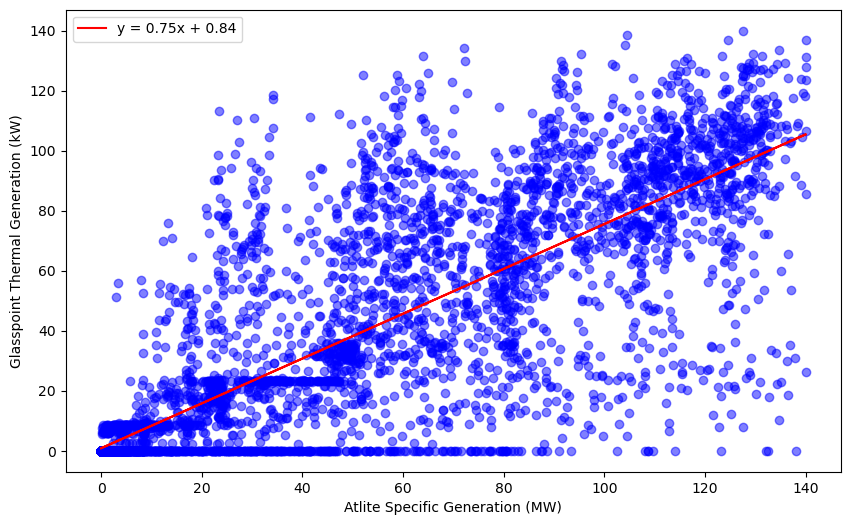

In [16]:
# Make a scatter plot of Glasspoint data vs. atlite data
print(csp_power_generation_df)
print(glasspoint_data)
plt.figure(figsize=(10, 6))
plt.scatter(
    csp_power_generation_df["thermal_output"],
    glasspoint_data["thermal_output"],
    alpha=0.5,
    color="blue",
)
# Add a linear fit
m = np.polyfit(
    csp_power_generation_df["thermal_output"], glasspoint_data["thermal_output"], 1
)
b = np.polyval(m, csp_power_generation_df["thermal_output"])
plt.plot(
    csp_power_generation_df["thermal_output"],
    b,
    color="red",
    label=f"y = {m[0]:.2f}x + {m[1]:.2f}",
)
plt.legend()

plt.xlabel("Atlite Specific Generation (MW)")
plt.ylabel("Glasspoint Thermal Generation (kW)")

# Save the plot
plt.savefig("cfs_comparison/generation_GP_Atlite_scatter.png", dpi=400)

# Save csp_power_generation_df to csv
csp_power_generation_df.to_csv("cfs_comparison/generation_AtliteMod.csv")



                     thermal_output  day_of_year  time_of_day  \
time                                                            
2018-09-25 21:00:00    0.000000e+00          268         21.0   
2018-09-25 15:00:00    0.000000e+00          268         15.0   
2018-05-16 02:00:00    0.000000e+00          136          2.0   
2018-05-16 01:00:00    0.000000e+00          136          1.0   
2018-09-26 03:00:00    0.000000e+00          269          3.0   
2018-09-26 02:00:00    0.000000e+00          269          2.0   
2018-09-26 01:00:00    0.000000e+00          269          1.0   
2018-09-26 00:00:00    0.000000e+00          269          0.0   
2018-09-25 23:00:00    0.000000e+00          268         23.0   
2018-09-25 22:00:00    0.000000e+00          268         22.0   
2018-09-25 16:00:00    0.000000e+00          268         16.0   
2018-09-25 20:00:00    0.000000e+00          268         20.0   
2018-05-16 23:00:00    0.000000e+00          136         23.0   
2018-05-16 22:00:00    0.

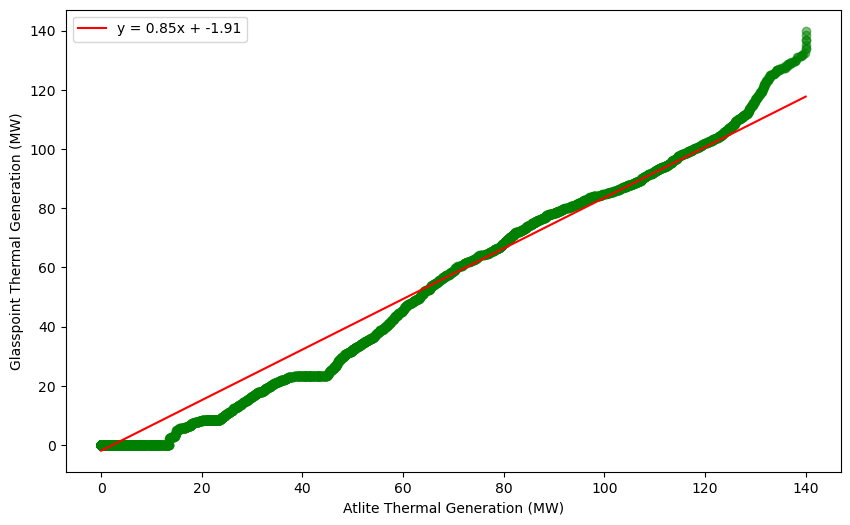

In [17]:
# Set the window size (in number of rows, not MW directly)
window_size = 15  # You can adjust based on data density

# Sort by thermal_output
binned_data = csp_power_generation_df.sort_values("thermal_output")
# Apply rolling median (or mean) over specific generation
binned_data["rolling_thermal_output"] = (
    binned_data["thermal_output"]
    .rolling(window=window_size, center=True)
    .median()
)

# Repeat for glasspoint_data
binned_glasspoint_data = glasspoint_data.sort_values("thermal_output")
binned_glasspoint_data["rolling_thermal_output"] = (
    glasspoint_data["thermal_output"]
    .rolling(window=window_size, center=True)
    .median()
)

print(binned_data)       
print(binned_glasspoint_data)

plt.figure(figsize=(10, 6))
plt.scatter(
    binned_data["thermal_output"],
    binned_glasspoint_data["thermal_output"],
    alpha=0.5,
    color="green",
)

# Add a linear fit
m = np.polyfit(
    binned_data["thermal_output"], binned_glasspoint_data["thermal_output"], 1
)
b = np.polyval(m, binned_data["thermal_output"])
plt.plot(
    binned_data["thermal_output"],
    b,
    color="red",
    label=f"y = {m[0]:.2f}x + {m[1]:.2f}",
)
plt.legend()


# Include 140 on x labels
plt.xticks(
    ticks=np.arange(0, 150, 20),
    labels=[str(int(x)) for x in np.arange(0, 150, 20)],
)
plt.xlabel("Atlite Thermal Generation (MW)")
plt.ylabel("Glasspoint Thermal Generation (MW)")

plt.savefig("cfs_comparison/generation_GP_Atlite_scatter_rolling_2018.png", dpi=400)

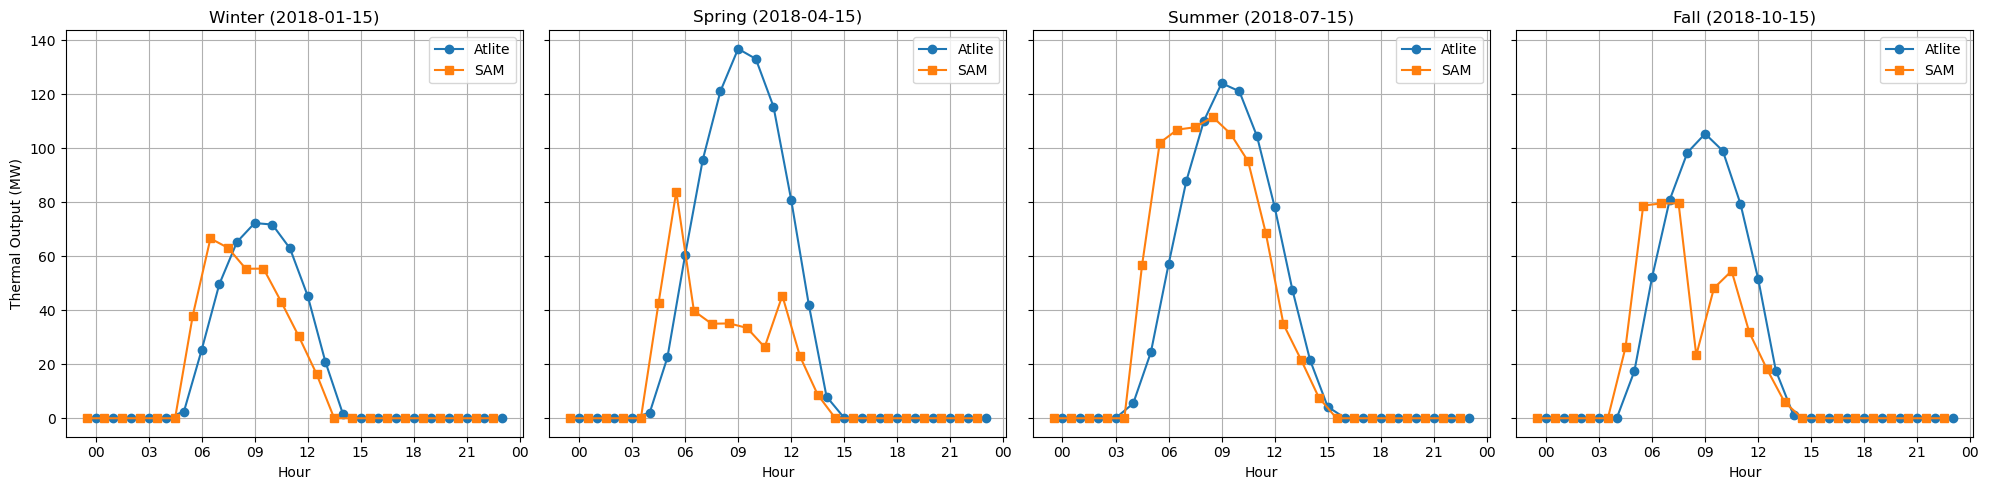

In [36]:
# Representative seasonal days
sample_days = {
    "Winter": "2018-01-15",
    "Spring": "2018-04-15",
    "Summer": "2018-07-15",
    "Fall":   "2018-10-15",
}

# Set up subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

for ax, (season, date) in zip(axes, sample_days.items()):
    ax.plot(csp_power_generation_df.loc[date].index, 
            csp_power_generation_df.loc[date]["thermal_output"], 
            label="Atlite", marker="o")
    
    ax.plot(glasspoint_data.loc[date].index - pd.Timedelta(minutes=30),
            glasspoint_data.loc[date]["thermal_output"], 
            label="SAM", marker="s")
    
    ax.set_title(f"{season} ({date})")
    ax.set_xlabel("Hour")
    # x ticks should not repeat the day
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))


    if season == "Winter":
        ax.set_ylabel("Thermal Output (MW)")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.savefig("cfs_comparison/generation_GP_Atlite_days.png", dpi=400)


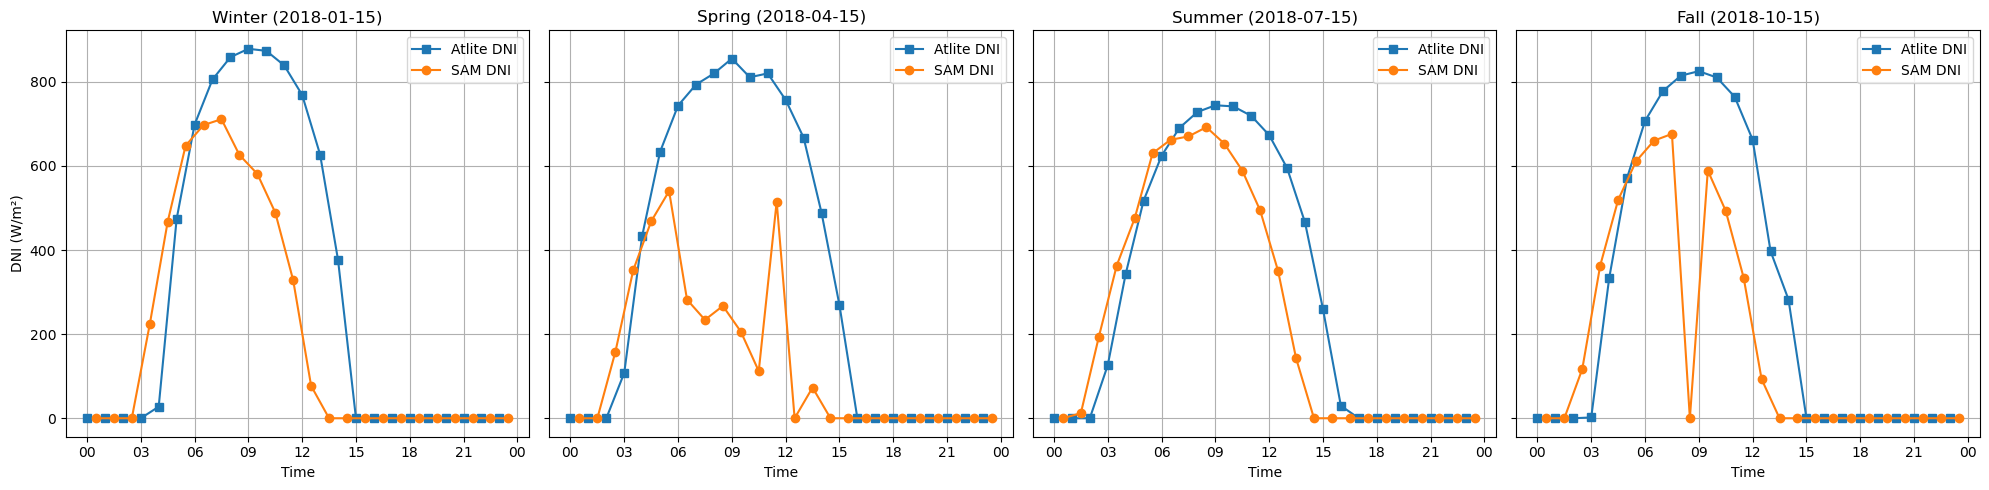

In [35]:
# Load the uploaded DNI datasets
sam_weather_path = "SAM_weather_RasAlKhair_2018.csv"
atlite_radiation_path = "az_alt_downRad_SaudiArabia.csv"

# Load data
sam_weather_df = pd.read_csv(sam_weather_path, skiprows=2)
atlite_rad_df = pd.read_csv(atlite_radiation_path)

# Parse timestamps
sam_weather_df["time"] = pd.to_datetime(sam_weather_df[["Year", "Month", "Day", "Hour"]]) - pd.Timedelta(minutes=30)
atlite_rad_df["time"] = pd.to_datetime(atlite_rad_df["time (UTC)"])

# Extract seasonal days for plotting
sample_days = {
    "Winter": "2018-01-15",
    "Spring": "2018-04-15",
    "Summer": "2018-07-15",
    "Fall":   "2018-10-15",
}

# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

for ax, (season, date) in zip(axes, sample_days.items()):

    atlite_day = atlite_rad_df[atlite_rad_df["time"].dt.date == pd.to_datetime(date).date()]
    sam_day = sam_weather_df[sam_weather_df["time"].dt.date == pd.to_datetime(date).date()]

    ax.plot(atlite_day["time"], atlite_day["DNI (W/m^2)"], label="Atlite DNI", marker="s")
    ax.plot(sam_day["time"], sam_day["DNI"], label="SAM DNI", marker="o")
    
    ax.set_title(f"{season} ({date})")
    ax.set_xlabel("Time")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    if season == "Winter":
        ax.set_ylabel("DNI (W/m²)")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.savefig("cfs_comparison/generation_GP_Atlite_days_DNI_comparison.png", dpi=400)